In [266]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['countries.csv', 'sessions.csv', 'age_gender_bkts.csv', 'sample_submission.csv', 'train_users_2.csv', 'test_users.csv', 'sample_submission_NDF.csv']


# Data exploration
will go through each files and explore what features can be consider for modeling.
1. train_user file
2. sessions
3. countries
4. age_gender_bkts

In [267]:
#loading all the files and checking their shapes respectively
train_df = pd.read_csv('../input/train_users_2.csv',parse_dates=['date_account_created'])
test_df = pd.read_csv('../input/test_users.csv',parse_dates=['date_account_created'])
age_gender_df = pd.read_csv('../input/age_gender_bkts.csv')
countries_df = pd.read_csv('../input/countries.csv')
session_df = pd.read_csv('../input/sessions.csv')
train_df.shape,test_df.shape,age_gender_df.shape,countries_df.shape,session_df.shape

((213451, 16), (62096, 15), (420, 5), (10, 7), (10567737, 6))

## 1. EDA on train data frame

In [268]:
# lets see first 5 rows
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [269]:
#lets inspect the columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(12)
memory usage: 26.1+ MB


In [270]:
#first find out any missing values
(train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)

date_first_booking         0.583473
age                        0.412226
first_affiliate_tracked    0.028414
country_destination        0.000000
first_browser              0.000000
first_device_type          0.000000
signup_app                 0.000000
affiliate_provider         0.000000
affiliate_channel          0.000000
language                   0.000000
signup_flow                0.000000
signup_method              0.000000
gender                     0.000000
timestamp_first_active     0.000000
date_account_created       0.000000
id                         0.000000
dtype: float64

as age, date_first_booking are having almost 50 % missing values.
* we could consider removing data_first_booking colum as we cant impute it's missing values with  any of the methods like(mean, 90%, etc..)
* about age colum we try out possibilities of imputing with (avg, 90%)

In [271]:
#lets see value counts for each of the categorical columns to  see if any of the values hardcoded in some common formate
category_columns = list(train_df.columns[train_df.dtypes == np.object].values)
category_columns.remove('date_first_booking') #doesnt make any sense to  see how many unique dates are present
category_columns.remove('country_destination') #target column 
category_columns.remove('id') #because it's unique one
print(category_columns)

['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']


In [272]:
#lets print values counts for above columns
for a in category_columns:
    print(train_df[a].value_counts(),'value coutns',a)

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64 value coutns gender
basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64 value coutns signup_method
en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
th        24
el        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64 value coutns language
direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64 value coutns affiliate_channel
direct                 137426
google                  51693
other                   12549
craigslist               3471
bi

we can see except gender all values makes sense,

So we should consider doing some kind of imputation to the gender column.

And we can get dummy variables for all the category columns

In [273]:
#lets analysis for remainng columns
remaining_columns = list(train_df.columns[train_df.dtypes != np.object].values)
remaining_columns

#we can convert timestamp_first_active to date one
train_df.timestamp_first_active = train_df.timestamp_first_active.apply(lambda x:pd.to_datetime(str(x)))

In [274]:
import seaborn as sns

In [275]:
train_df.age.apply(lambda x : x>120).sum()

781

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


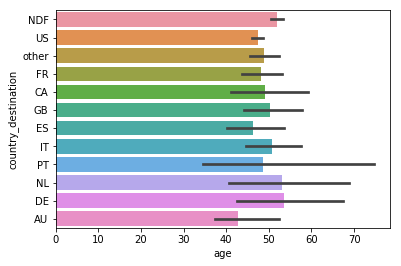

In [276]:
sns.barplot(data=train_df,x='age',y='country_destination')

In [277]:
train_df.first_browser.value_counts().sort_values(ascending=False)/train_df.first_browser.count()

Chrome                  0.299108
Safari                  0.211613
Firefox                 0.157671
-unknown-               0.127739
IE                      0.098702
Mobile Safari           0.090297
Chrome Mobile           0.005950
Android Browser         0.003987
AOL Explorer            0.001148
Opera                   0.000881
Silk                    0.000581
Chromium                0.000342
BlackBerry Browser      0.000248
Maxthon                 0.000216
Apple Mail              0.000169
IE Mobile               0.000169
Sogou Explorer          0.000155
Mobile Firefox          0.000141
RockMelt                0.000112
SiteKiosk               0.000112
Iron                    0.000080
IceWeasel               0.000061
Pale Moon               0.000056
SeaMonkey               0.000052
CometBird               0.000052
Yandex.Browser          0.000052
Camino                  0.000042
TenFourFox              0.000037
CoolNovo                0.000028
wOSBrowser              0.000028
Avant Brow

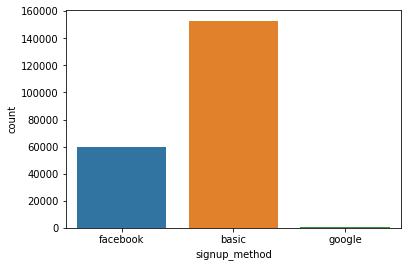

In [278]:
sns.countplot(data=train_df,x='signup_method')

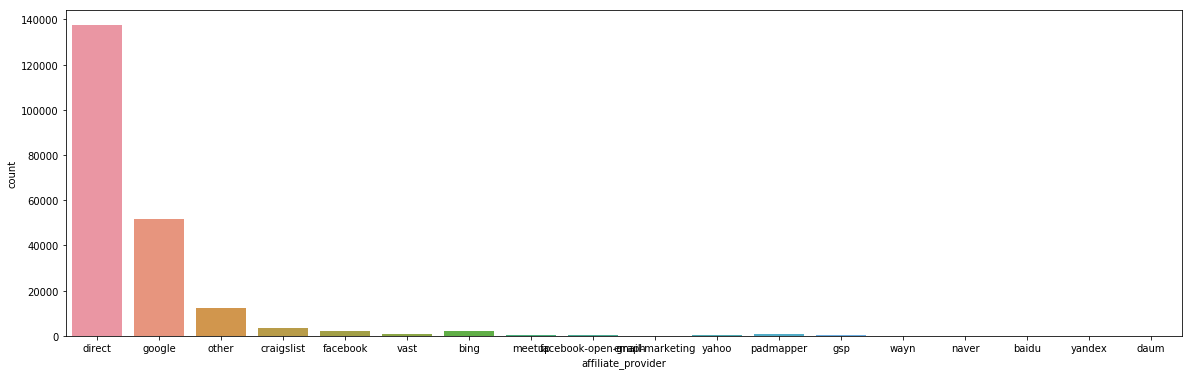

In [279]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
sns.countplot(data=train_df,x='affiliate_provider')

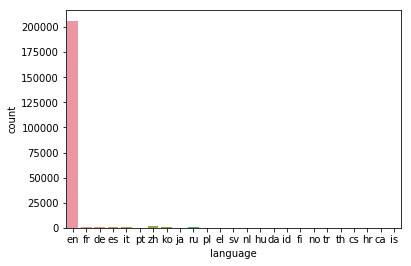

In [280]:
sns.countplot(data=train_df,x='language')

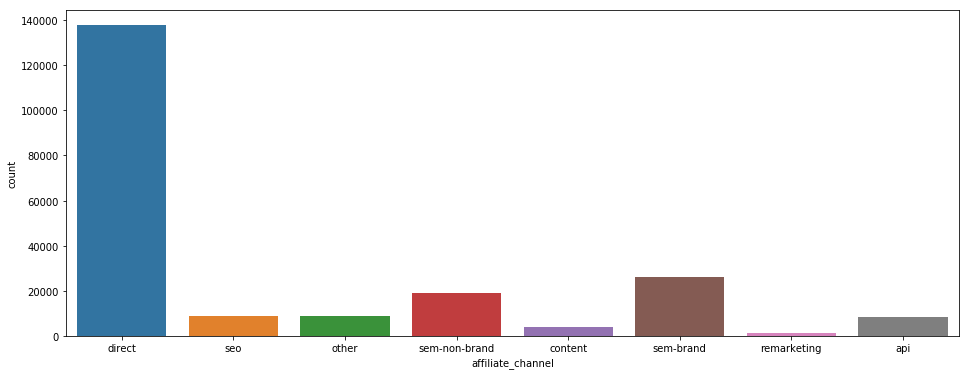

In [281]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df,x='affiliate_channel')

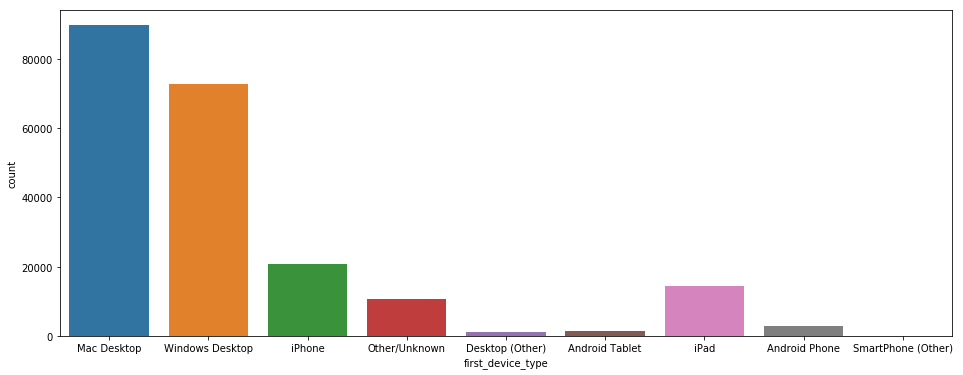

In [282]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df,x='first_device_type')

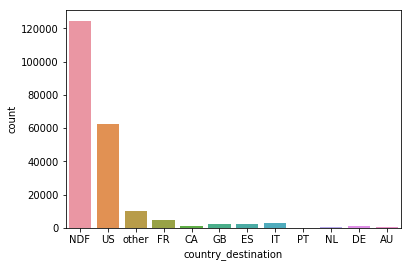

In [283]:
sns.countplot(data=train_df,x='country_destination')

In [287]:
# category_columns = list(train_df.columns[train_df.dtypes == np.object].values)

In [288]:
##Han

## Handling missing values

In [289]:
train_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [290]:
# train_df['gender']= train_df.gender.replace('-unknown-',np.nan)

In [291]:
train_df.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [292]:
train_df.isnull().sum().sort_values(ascending=False)

date_first_booking         124543
age                         87990
first_affiliate_tracked      6065
country_destination             0
first_browser                   0
first_device_type               0
signup_app                      0
affiliate_provider              0
affiliate_channel               0
language                        0
signup_flow                     0
signup_method                   0
gender                          0
timestamp_first_active          0
date_account_created            0
id                              0
dtype: int64

In [293]:
# train_df['first_browser']= train_df.first_browser.replace('-unknown-',np.nan)

In [294]:
#handling Age column
train_df.loc[train_df.age>120,'age'] = np.nan
train_df.age.fillna(train_df.age.mean(),inplace=True)

In [295]:
train_df.isnull().sum().sort_values(ascending=False)

date_first_booking         124543
first_affiliate_tracked      6065
country_destination             0
first_browser                   0
first_device_type               0
signup_app                      0
affiliate_provider              0
affiliate_channel               0
language                        0
signup_flow                     0
signup_method                   0
age                             0
gender                          0
timestamp_first_active          0
date_account_created            0
id                              0
dtype: int64

In [296]:
train_df.age.isnull().sum()

0

In [297]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Session data exploration : 


In [298]:
session_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [299]:
session_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [300]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [301]:
total_seconds = session_df.groupby('user_id')['secs_elapsed'].sum()

In [302]:
average_seconds = session_df.groupby('user_id')['secs_elapsed'].mean()

In [303]:
total_sessions = session_df.groupby('user_id')['secs_elapsed'].count()

In [304]:
unique_sessions = session_df.groupby('user_id')['secs_elapsed'].nunique()

In [305]:
total_seconds.head(),total_sessions.head(),average_seconds.head(),unique_sessions.head()

(user_id
 00023iyk9l     867896.0
 0010k6l0om     586543.0
 001wyh0pz8     282965.0
 0028jgx1x1     297010.0
 002qnbzfs5    6487080.0
 Name: secs_elapsed, dtype: float64, user_id
 00023iyk9l     39
 0010k6l0om     62
 001wyh0pz8     89
 0028jgx1x1     30
 002qnbzfs5    788
 Name: secs_elapsed, dtype: int64, user_id
 00023iyk9l    22253.743590
 0010k6l0om     9460.370968
 001wyh0pz8     3179.382022
 0028jgx1x1     9900.333333
 002qnbzfs5     8232.335025
 Name: secs_elapsed, dtype: float64, user_id
 00023iyk9l     38
 0010k6l0om     59
 001wyh0pz8     86
 0028jgx1x1     30
 002qnbzfs5    609
 Name: secs_elapsed, dtype: int64)

In [306]:
num_short_sessions = session_df[session_df['secs_elapsed'] <= 300].groupby('user_id')['secs_elapsed'].count()
num_long_sessions = session_df[session_df['secs_elapsed'] >= 2000].groupby('user_id')['secs_elapsed'].count()

In [307]:
num_long_sessions.head(),num_short_sessions.head()

(user_id
 00023iyk9l     13
 0010k6l0om     20
 001wyh0pz8     23
 0028jgx1x1     15
 002qnbzfs5    243
 Name: secs_elapsed, dtype: int64, user_id
 00023iyk9l      9
 0010k6l0om     25
 001wyh0pz8      9
 0028jgx1x1     14
 002qnbzfs5    336
 Name: secs_elapsed, dtype: int64)

In [308]:
num_devices = session_df.groupby('user_id')['device_type'].nunique()

In [309]:
def session_id_features(df):
    df['total_seconds'] = df['id'].apply(lambda x:total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x:average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x:total_sessions[x] if x in  total_sessions else 0)
    df['unique_sessions'] = df['id'].apply(lambda x:unique_sessions[x] if x in  unique_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x:num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x:num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x:num_devices[x] if x in num_devices else 0)
    return df

In [310]:
train_df.shape

(213451, 16)

In [311]:
train_df = session_id_features(train_df)

In [312]:
train_df[train_df.average_seconds.isnull()]
train_df.average_seconds.fillna(0,inplace=True)

In [313]:
train_df.isnull().sum().sort_values(ascending=False)

date_first_booking         124543
first_affiliate_tracked      6065
affiliate_provider              0
date_account_created            0
timestamp_first_active          0
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
num_devices                     0
num_long_sessions               0
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
total_seconds                   0
average_seconds                 0
total_sessions                  0
unique_sessions                 0
num_short_sessions              0
id                              0
dtype: int64

In [314]:
def language(df):
    df['language'] = df['language'].apply(lambda x:'foreign' if x!='en' else x)
    return df

In [315]:
def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x:'rest' if x not in 
                                                              ['direct','google','other'] else x)
    return df

In [316]:
def browser(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x=='Mobile Safari' else x)
    major_browser = ['Chrome','Safari','Firefox','IE','Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x : 'Other' if x not in major_browser else x)
    return df

In [317]:
def classify_device(x):
    if x.find('Desktop') != -1:
        return  "Desktop"
    elif x.find("Tablet") != -1 or x.find('iPad') != -1:
        return "Tablet"
    elif x.find('Phone') != -1:
        return  "Phone"
    else:
        return "Unknown"

In [318]:
train_df = language(train_df)
train_df = affiliate_provider(train_df)
train_df = browser(train_df)

In [319]:
train_df.shape

(213451, 23)

In [320]:
train_df.drop(['date_first_booking','date_account_created','timestamp_first_active'],axis=1,inplace=True)
train_df = pd.get_dummies(train_df,columns=category_columns,drop_first=True)

In [321]:
X_train,X_test,y_train,y_test = train_test_split(train_df.drop(['country_destination','id'],axis=1),train_df['country_destination'],test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((149415, 47), (64036, 47), (149415,), (64036,))

In [322]:

lg = LogisticRegression()
lg.fit(X_train,y_train)
lg.score(X_test,y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5819539009307265

In [323]:

lg.score(X_train,y_train)

0.584740487902821

In [324]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()


In [ ]:
gbc.fit(X_train,y_train)

In [ ]:
gbc.score(X_train,y_train)